# DECO SCRIPT :
- Version : 13 / 04 / 2024 (13th April 2024)
- Author : Benoit Pierson
- Mail : benoitmarc.pierson@gmail.com

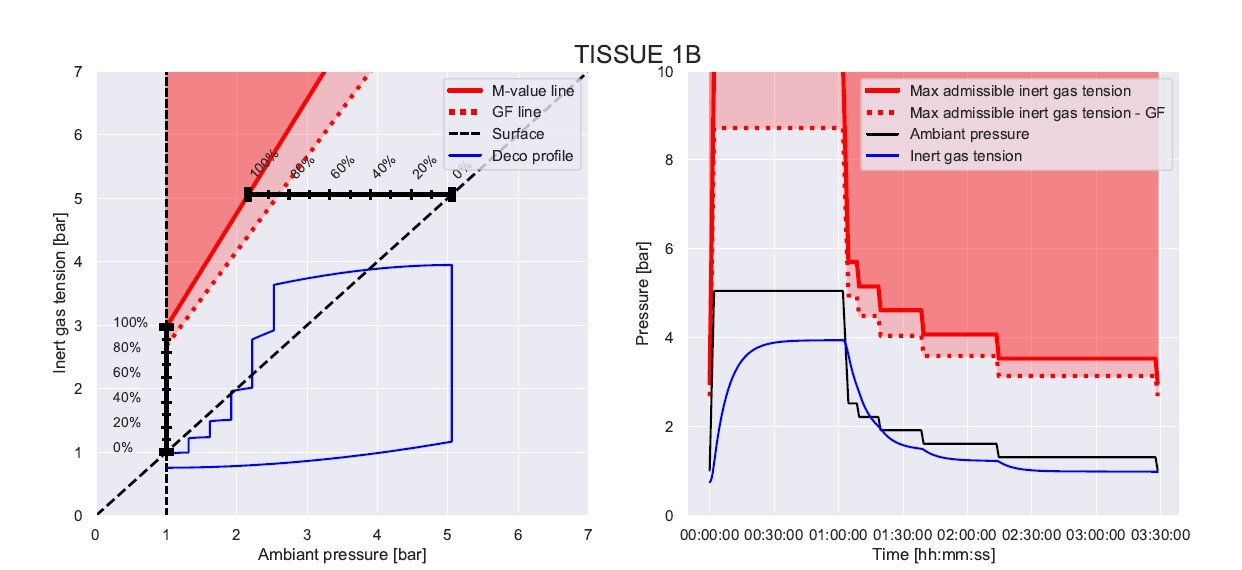

# SCOPE : 

- The aim of this work is to give an overview of the methodology used by a diving computer, not to replace it or to plan a dive !

- This is a non-certifies work. This work has not been checked properly (no peer review process) as it has to be for a real usage

- This notebook is useful if you want to visualize tissues saturations along time for a given dive (see at the end of this notebook)

# HYPOTHESIS : 
- We consider Buhlmann ZHL16-C model for M-values and half-times of 16 tissues
- We let the user choose the proper gradient factor he wants to use
- For the first tissue, we consider 1b
- Speed at descent is 20m/s
- Speed ascent is 10m/s to the first deco stop, 3m/s between deco stops, 3m/s to the surface (high considering common used values ~ 1m/s in last meters of ascent

In [1]:
from datetime import datetime, timedelta
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set_theme()

# 1 - Definition of constants

In [2]:
rho_water = 1030.0 # Water density [kg/m**3]
p_water_vapor = 0.0627 # Water vapor pressure in lungs [bar]
p_atm_sea_level = 1.01325 # Ambiant pressure at sea level [bar]
g = 9.81 # gravity [m*s**-2]

In [11]:
def get_M_values(file_path):
    df_M_Values = pd.read_csv(file_path, sep = ";")
    M_values = {}
    for i in range(len(df_M_Values)):
        cell = df_M_Values.iloc[i]['Cell']
        HT = df_M_Values.iloc[i]['Half-time [sec]']
        M0 = df_M_Values.iloc[i]['M0']
        M_slope = df_M_Values.iloc[i]['M_slope']
        M_values[cell] = {}
        M_values[cell]["HT"] = HT
        M_values[cell]["M0"] = M0
        M_values[cell]["M_Slope"] = M_slope       
    return M_values



def define_dive_profile(depth, diving_time, desc_speed):
    descent_time = depth / desc_speed    
    start_time = datetime(1900, 1, 1, 0, 0, 0)
    bottom_arrival_time = start_time + timedelta(seconds = descent_time)
    end_time = bottom_arrival_time + timedelta(minutes = diving_time)
    df = pd.DataFrame({
        'Temps' : [start_time, bottom_arrival_time, end_time],
        'Profondeur [m]'  : [0., depth, depth]})
    return df
    


def shreiner(k, R, P0, Pi0, t):
    # k : half-time constant = ln2/half-time [sec**-1]
    # R : rate of change in inspired gas pressure with change in ambient pressure [bar / sec]
    # Pi0 : initial inspired (alveolar) inert gas pressure [bar]
    # P0 : initial compartment inert gas pressure [bar]
    P = Pi0 + R * (t - (1/k)) - (Pi0 - P0 - (R/k)) * np.exp(-k*t)
    return P



def calculate_cell_saturation(df):
    nb_steps = len(df)
    time_steps = list(df["Temps"])
    depth_steps = list(df["Profondeur [m]"])
    for cell in M_values.keys():
        HT = M_values[cell]['HT']
        k = np.log(2) / HT
        cell_saturation_along_times = list()
        for i in range(nb_steps):
            if (i == 0): 
                cell_saturation_along_times.append(0.79 * (p_atm_sea_level - p_water_vapor))
            else:
                P0 = cell_saturation_along_times[-1] # initial compartment inert gas pressure [bar]
                Pamb = p_atm_sea_level + (depth_steps[i-1] * rho_water * g) / 1E5
                Pi0 = N2Part * (Pamb - p_water_vapor) # initial inspired (alveolar) inert gas pressure [bar]
                depth_delta = depth_steps[i] - depth_steps[i-1]
                time_delta = (time_steps[i] - time_steps[i-1]).total_seconds()
                desc_speed = depth_delta / time_delta
                R = N2Part * desc_speed * ((rho_water * g) / 1E5) # R = rate of change in inspired gas pressure with change in ambient pressure [bar / sec]
                t = time_delta # time
                cell_saturation_along_times.append(shreiner(k, R, P0, Pi0, t))            
        df['pN2_cell_' + cell + ' [bar]'] = cell_saturation_along_times
    return df



def define_possible_deco_stops(df):
    possible_deco_stops = [*range(0, 1 + int(np.floor(df['Profondeur [m]'].max())), 3)]
    return possible_deco_stops


def pressure_at_depth(depth):
    return p_atm_sea_level + (rho_water * g * depth) / 1E5



def get_next_deco_stop(df, M_values, possible_deco_stops, GF_max_adm, ascent_speed):
    is_deco_stop_admissible = False
    for deco_stop_candidate in possible_deco_stops:
        is_deco_stop_admissible = True
        for cell in M_values.keys():         
            M0 = M_values[cell]['M0']
            M_slope = M_values[cell]['M_Slope']
            p_amb_stop_candidate = pressure_at_depth(deco_stop_candidate)
            M_value = M0 + M_slope * (p_amb_stop_candidate - p_atm_sea_level)
            max_adm_inert_gas_pressure = (1 - GF_max_adm) * p_amb_stop_candidate + GF_max_adm * M_value
            p_inert_gas_candidate = calculate_cell_saturation_after_ascent(df, cell, deco_stop_candidate, ascent_speed)
            if (p_inert_gas_candidate > max_adm_inert_gas_pressure):
                is_deco_stop_admissible = False 
        if (is_deco_stop_admissible):
            break
    return deco_stop_candidate

            
def calculate_cell_saturation_after_ascent(df, cell, depth_stop, ascent_speed):
    depth_current = df['Profondeur [m]'].values[-1]
    HT = M_values[cell]['HT']
    k = np.log(2) / HT
    P0 = df['pN2_cell_' + str(cell) + ' [bar]'].values[-1]
    Pamb = p_atm_sea_level + (depth_current * rho_water * g) / 1E5
    Pi0 = N2Part * (Pamb - p_water_vapor)
    R = - N2Part * ascent_speed * ((rho_water * g) / 1E5)
    t = np.abs(depth_current - depth_stop) / ascent_speed
    return shreiner(k, R, P0, Pi0, t)



def interpolate_max_GF_at_depth(depth, first_deco_depth, GF_low, GF_high):
    return GF_high - ((GF_high - GF_low) * depth / first_deco_depth)


def calculate_ascent_profile(df):
    ascent_beginning = True
    
    while (df['Profondeur [m]'].values[-1] != 0):
    
        if (ascent_beginning):
            first_deco_stop = get_next_deco_stop(df, M_values, possible_deco_stops, GF_low, ascent_speed)
            depth = first_deco_stop
            ascent_duration = np.abs(first_deco_stop - df['Profondeur [m]'].values[-1]) / ascent_speed
            time = df['Temps'].values[-1] + np.timedelta64(int(np.ceil(ascent_duration)), 's')
            df = df.append({'Temps' : time, 'Profondeur [m]' : depth}, ignore_index = True)
            df = calculate_cell_saturation(df)
            ascent_beginning = False
        
        else:
            depth = df['Profondeur [m]'].values[-1]
            GF_max = interpolate_max_GF_at_depth(depth, first_deco_stop, GF_low, GF_high)
            next_depth = get_next_deco_stop(df, M_values, possible_deco_stops, GF_max, ascent_speed_between_stops)
        
            if (depth == next_depth):
                time = df['Temps'].values[-1] + np.timedelta64(60, 's')
                df = df.append({'Temps' : time, 'Profondeur [m]' : depth}, ignore_index = True)
                df = calculate_cell_saturation(df)
            
            else:
                ascent_duration = 3 / ascent_speed_between_stops
                time = df['Temps'].values[-1] + np.timedelta64(int(np.ceil(ascent_duration)), 's')
                df = df.append({'Temps' : time, 'Profondeur [m]' : depth - 3}, ignore_index = True)
                df = calculate_cell_saturation(df)
    
    df_g = df.iloc[1:].groupby(['Profondeur [m]']).agg({'Temps' : ['min', 'max']}).reset_index(drop = False)
    df_g.columns = ['Profondeur [m]', 'Temps - min', 'Temps - max']
    df_g['Duration at depth'] = ((df_g['Temps - max'] - df_g['Temps - min']).dt.total_seconds() / 60).astype('int')
    df_g = df_g.sort_values(by = "Temps - min").reset_index(drop = True)
    df_g['Ascent duration'] = 0.
    for i in range(1, len(df_g)):
        df_g['Ascent duration'].iloc[i] = np.ceil((df_g['Temps - min'].iloc[i] - df_g['Temps - max'].iloc[i-1]).total_seconds() / 60)
    df_g['Ascent duration'] = df_g['Ascent duration'].astype('int')
    df_g['Temps - min'] = df_g['Temps - min'].dt.time
    df_g['Temps - max'] = df_g['Temps - max'].dt.time
    df_g = df_g[['Profondeur [m]', 'Temps - min', 'Temps - max', 'Ascent duration', 'Duration at depth']]
    
    return df, df_g, first_deco_stop


In [12]:
GF_low = 0.9
GF_high = 0.9
N2Part = 0.79
descent_speed = 20 / 60
ascent_speed = 10 / 60
ascent_speed_between_stops = 3 / 60

M_values = get_M_values("Buhlmann_Zh-L16C_M-values.csv")
df = define_dive_profile(depth = 60, diving_time = 30, desc_speed = descent_speed)
df = calculate_cell_saturation(df)
possible_deco_stops = define_possible_deco_stops(df)
df, deco_planner, first_deco_stop = calculate_ascent_profile(df)               

C:\Users\benoi\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [13]:
deco_planner

,Profondeur [m],Temps - min,Temps - max,Ascent duration,Duration at depth
0,60.0,00:03:00,00:33:00,0,30
1,18.0,00:37:12,00:40:12,5,3
2,15.0,00:41:12,00:46:12,1,5
3,12.0,00:47:12,00:54:12,1,7
4,9.0,00:55:12,01:10:12,1,15
5,6.0,01:11:12,01:38:12,1,27
6,3.0,01:39:12,02:31:12,1,52
7,0.0,02:32:12,02:32:12,1,0


In [14]:
end = deco_planner['Temps - min'].values[-1]
for i in range(0, end.hour * 3600 + end.minute * 60 + end.second):
    print(i)